*Antonio Coín Castro*


# Bayesian Functional Linear Regression

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display, Math

import corner
import pickle
from multiprocessing import Pool
#import sys
# sys.path.append("..")
#import flr

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 4]

seed = 42
np.random.seed(seed)
np.set_printoptions(precision=3, suppress=True)
rng = np.random.default_rng(seed)

Let's impose a discrete prior on $p \in \{1, \dots, 6\}$ given by the following probabilities:
\begin{align*}
\pi(p=1) &= 0.05\\
\pi(p=2) &= 0.1\\
\pi(p=3) &= 0.3\\
\pi(p=4) &= 0.3\\
\pi(p=5) &= 0.15\\
\pi(p=6) &= 0.1
\end{align*}

Writing the parameter vector as $\theta = (p, \beta, \tau, \sigma^2)$, the joint prior distribution is:
$$
\pi(\theta) = \pi(\beta \mid p, \tau, \sigma^2)\pi(\tau\mid p, \sigma^2)\pi(p\mid \sigma^2)\pi(\sigma^2).
$$

On the other hand, the joint posterior distribution is:
$$
\pi(p, \beta, \tau, \sigma^2\mid Y) \propto \pi(p)\frac{|G_\tau|^{1/2}}{\sigma^{p+n+2}} \exp\left\{ -\frac{1}{2\sigma^2} \left(\|Y- \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right) \right\}.
$$

Hence, the log-posterior probability is:

$$
\log \pi(p, \beta, \tau, \sigma^2\mid Y) \propto \log \pi(p) + \frac{1}{2}\log |G_\tau| - (p+n+2)\log \sigma -\frac{1}{2\sigma^2} \left(\|Y- \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right).  
$$

## Example dataset

We generate a toy dataset with $n=100$ functional regressors $X_i(t) \sim BM$, a "simple" RKHS function and a variance of $\sigma^2=1$:

$$
Y_i \sim \mathcal N(-5X_i(0.1) + 10X_i(0.8), 1).
$$

We consider a regular grid of $N=100$ points on $[0, 1]$.

In [3]:
def brownian_kernel(s, t, sigma=1.0):
    return sigma*np.minimum(s, t)


def cov_matrix(kernel_fn, s, t):
    ss, tt = np.meshgrid(s, t, indexing='ij')

    # Evaluate the kernel over meshgrid (vectorized operation)
    K = kernel_fn(ss, tt)

    return K


def generate_gp_dataset(grid, kernel_fn, n_samples, beta, tau, var_error):
    """Generate dataset based on GP with a given kernel function."""
    N = len(grid)
    p = len(beta)
    mean_vector = np.zeros(N)
    kernel_matrix = cov_matrix(kernel_fn, grid, grid)
    idx = np.abs(np.subtract.outer(grid, tau)).argmin(0)

    X = rng.multivariate_normal(mean_vector, kernel_matrix, size=n_samples)
    X_tau = X[:, idx]
    error = np.sqrt(var_error)*rng.standard_normal(size=n_samples)
    Y = X_tau@beta + error

    return X, Y

In [4]:
N = 100
n = 100
grid = np.linspace(0., 1., N + 1)
beta_true = np.array([-5., 10.])
tau_true = np.array([0.1, 0.8])
sigma2_true = 1.0
truths = np.concatenate((beta_true, tau_true, [sigma2_true]))

X, Y = generate_gp_dataset(grid, brownian_kernel, n,
                           beta_true, tau_true, sigma2_true)

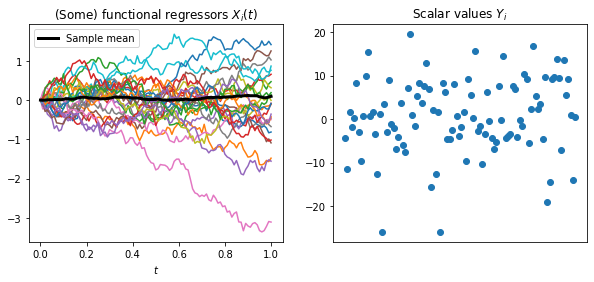

In [5]:
fig, axs = plt.subplots(1, 2)

axs[0].set_title(r"(Some) functional regressors $X_i(t)$")
axs[0].set_xlabel(r"$t$")
axs[0].plot(grid, X.T[:, :n//4])
axs[0].plot(
    grid, np.mean(X, axis=0),
    linewidth=3, color='k',
    label="Sample mean")
axs[0].legend()
axs[1].set_title(r"Scalar values $Y_i$")
axs[1].set_xticks([])
axs[1].scatter(range(n), Y);

## The Ensemble Sampler and the *emcee* library

In [6]:
import emcee

In [7]:
# Constant parameters are global for efficient parallelization
def log_prob(theta):
    """Global parameters: X, b0, g, grid, p_mass"""

    n, N = X.shape
    max_p = len(p_mass)

    # Get parameters
    p = int(np.rint(theta[0]))   # Round 'p' to nearest integer
    beta = theta[1:max_p + 1]
    tau = theta[max_p + 1:2*max_p + 1]
    sigma2 = theta[-1]

    # Impose constraints on parameters
    if (tau < 0).any() or (tau > 1).any() or sigma2 <= 0 or p < 1 or p > max_p:
        return -np.inf

    idx = np.abs(np.subtract.outer(grid, tau)).argmin(0)
    X_tau = X[:, idx]
    G_tau = X_tau.T@X_tau
    det = np.linalg.det(G_tau)
    b = beta - b0

    # For the time being, ignore poor conditioning on G
    if not np.isfinite(det) or det <= 0:
        return -np.inf

    log_posterior = (np.log(p_mass[p])
                     + 0.5*np.log(det)
                     - (p + n + 2)*np.log(np.sqrt(sigma2))
                     - 0.5*(1./sigma2)*(np.linalg.norm(Y - X_tau@beta)**2
                                        + (1./g)*b.T@G_tau@b))

    # Avoid unexpected errors
    if np.isfinite(log_posterior):
        return log_posterior
    else:
        return -np.inf


def initial_guess(n_walkers, max_p, sd_beta):
    p_init = rng.integers(1, max_p, size=(n_walkers, 1), endpoint=True)
    beta_init = sd_beta*rng.standard_normal(size=(n_walkers, max_p))
    tau_init = rng.uniform(size=(n_walkers, max_p))
    sigma2_init = 1./rng.standard_gamma(shape=1, size=(n_walkers, 1))

    return np.hstack((
        p_init,
        beta_init,
        tau_init,
        sigma2_init
    ))

In [8]:
p_mass = {1: 0.05, 2: 0.4, 3: 0.45, 4: 0.1}
max_p = len(p_mass)
labels = [r"$p$"]
for i in range(max_p):
    labels.append(fr"$\beta_{i + 1}$")
for i in range(max_p):
    labels.append(fr"$t_{i + 1}$")
labels.append(r"$\sigma^2$")

In [9]:
n_dim = 2*max_p + 2
n_walkers = 150
n_iter_initial = 200
n_iter = 15000

g = 5
b0 = g*rng.standard_normal(size=max_p)
p0 = initial_guess(n_walkers, max_p, g)

In [16]:
with Pool(4) as pool:
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_prob, pool=pool)
    state = sampler.run_mcmc(
        p0, n_iter_initial, progress='notebook')  # burn-in phase
    sampler.reset()
    sampler.run_mcmc(state, n_iter, progress='notebook')

  0%|          | 0/200 [00:00<?, ?it/s]

/home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


  0%|          | 0/15000 [00:00<?, ?it/s]

In [17]:
print(
    f"Mean acceptance fraction: {100*np.mean(sampler.acceptance_fraction):.3f}%")
print(
    f"Autocorrelation times: {sampler.get_autocorr_time()}")

Mean acceptance fraction: 20.725%


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 10 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: [430.017 500.964 412.555 670.204 450.967 727.852 415.039 399.906 405.868
 462.394]

We analyze the samples of all chains, discarding the first 500 and then taking only every 20th sample.

In [18]:
samples = sampler.get_chain(discard=500, thin=20)     # Separate chains
samples_flat = samples.reshape(-1, samples.shape[-1])  # All chains combined

samples_all = sampler.get_chain(discard=500)           # No thinning performed
samples_all_flat = samples_all.reshape(-1, samples_all.shape[-1])

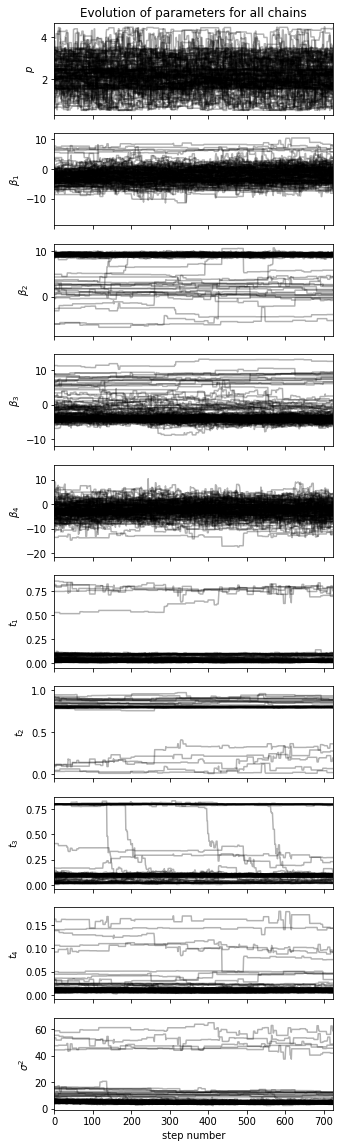

In [19]:
fig, axes = plt.subplots(n_dim, figsize=(5, 20), sharex=True)

for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples_all[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.set_xlim(0, len(samples))

axes[0].set_title("Evolution of parameters for all chains")
axes[-1].set_xlabel("step number");

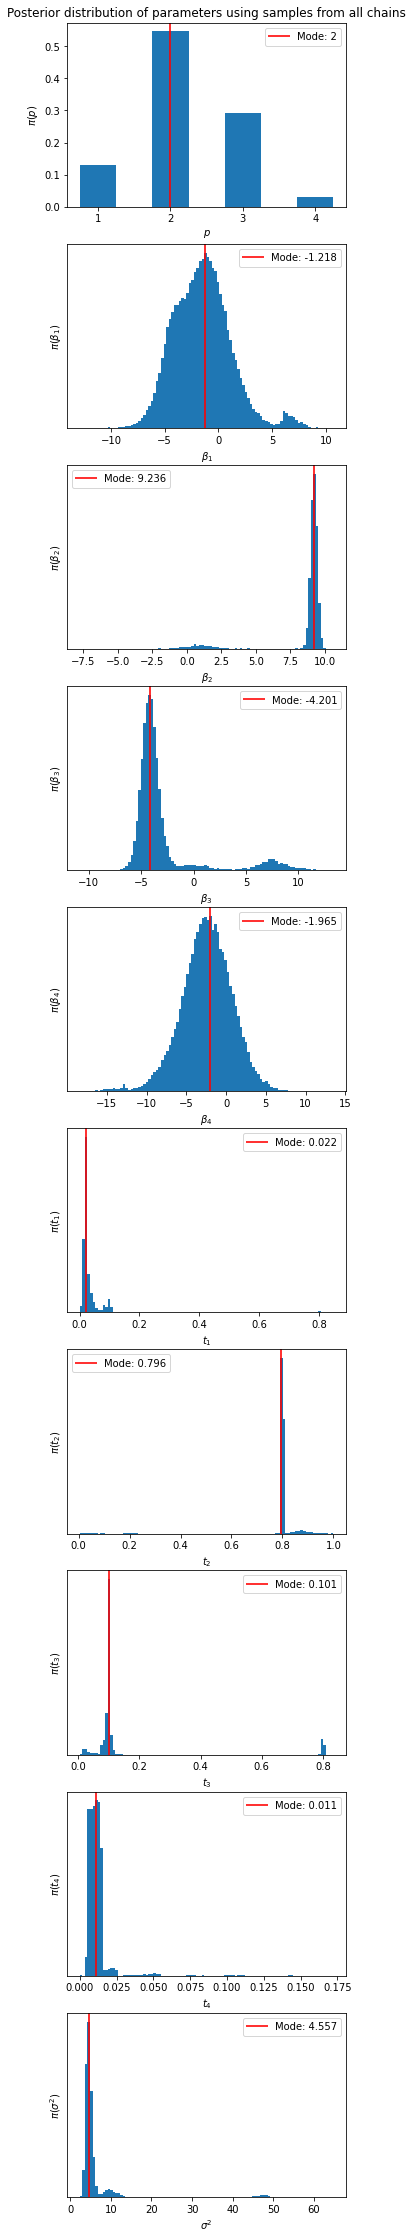

In [20]:
fig, axes = plt.subplots(n_dim, figsize=(5, 40))

# Bar chart for the posterior of 'p'
n_samples = samples_flat.shape[0]
samples_p_int = np.zeros(n_samples)
for i in range(n_samples):
    samples_p_int[i] = np.rint(samples_flat[i, 0])
    
xp, yp = np.unique(samples_p_int, return_counts=True)   
axes[0].bar(xp, yp/np.sum(yp), width=0.5)
mode = int(xp[np.argmax(yp)])
axes[0].axvline(mode, label=f"Mode: {mode}",
               color="red", lw=2, alpha=0.8)  # mode
axes[0].legend()
axes[0].set_xlabel(labels[0])
axes[0].set_xticks(xp)
axes[0].set_ylabel(r"$\pi$(" + labels[0] + ")")
axes[0].set_title(r"Posterior distribution of parameters using samples from all chains");
    
# Histogram for the posterior of the rest of parameters
for i in range(1, n_dim):
    ax = axes[i]
    nn, bins, _ = ax.hist(
        samples_flat[:, i],
        bins=100,
        density=True)
    max_bin = nn.argmax()
    mode = bins[max_bin:max_bin + 2].mean()
    ax.set_xlabel(labels[i])
    ax.axvline(mode, label=f"Mode: {mode:.3f}",
               color="red", lw=2, alpha=0.8)  # mode
    ax.legend()
    ax.set_ylabel(r"$\pi$(" + labels[i] + ")")
    ax.set_yticks([])

In [21]:
mean_values = np.mean(samples, axis=(0, 1))
print(f"Mean values in the marginalized posteriors:")
for i in range(n_dim):
    txt = "{1} = ${0:.3f}$"
    txt = txt.format(mean_values[i], labels[i])
    display(Math(txt))

Mean values in the marginalized posteriors:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [22]:
print("Medians and 95% credible intervals in the marginalized posteriors:")
for i in range(n_dim):
    mcmc = np.percentile(samples_flat[:, i], [2.5, 50, 97.5])
    txt = "{3} = ${0:.3f}_{{{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], mcmc[0], mcmc[2], labels[i])
    display(Math(txt))

Medians and 95% credible intervals in the marginalized posteriors:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [23]:
with open("sampler-p-free.mcmc", 'wb') as file:
    pickle.dump(sampler, file)
    file.close()

In [41]:
with open("sampler-p-free.mcmc", 'rb') as file:
    sampler = pickle.load(file)
    file.close()

## The PyMC library

In [ ]:
import pymc3